# Analysis of Model

Here, we load the weights of a fully trained model of the Gaussian beam propagation in order to do graphics and other stuff.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from time import time

In [2]:
save_to_thesis = True

In [3]:
boundary_condition = 'nobound'

In [4]:
folder = f'/home/jakob/OneDrive/Physik/SemesterVI/ThesisTeX/graphics/chapter4_gaussian_{boundary_condition}'

In [5]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [6]:
tf.random.set_seed(42) # always the same seed - reproducibility

In [7]:
pi = tf.constant(np.pi, dtype=DTYPE) # everybody needs some pi in their life

2022-07-04 10:14:09.948248: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-04 10:14:09.948559: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-04 10:14:09.949480: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
plt.style.use('rc.mplstyle')

In [9]:
plt.rcParams['axes.grid'] = False   # otherwise he dislikes colorplots

### parameters

In [10]:
number = 27

In [11]:
with open(f'documentation/calc{number}.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

Documentation for Calculation 27

2D Gaussian beam, normalized

Boundary condition: dirichlet

Optimizer: Adam till 12000, L-BFGS from 12000 to 17000

5 Layers and 32 nodes per layer

Learning rate is 0.001, residual weights is 0.001

Bound weight is 0 and initial weight is 1.0

A_0 = 1.0 and z_0 = 1.0

x_lb = -1 and x_ub = 1

z_lb = 0.0 and z_ub = 1.0

N = 10000 and N_test = 101 and N_b / N_0 = 200

Curriculum = FALSE

EXTRA INFO: float is float32


In [12]:
A_0 = 1.
z_0 = 1.

x_lb = -1
x_ub = 1
z_lb = 0
z_ub = 1

if number == 26 or number == 29 or number == 30 or number == 34:
    x_lb = -0.5
    x_ub = 0.5
    
if boundary_condition == 'nobound_extrapol' or boundary_condition == 'periodic_extrapol':
    x_lb = -2
    x_ub = 2
    z_lb = 0
    z_ub = 2
    
maxepoch = 12000
lbfgs_add = 5000
lr = 1e-3
phylr = [1e-3, 0, 1.]
num_layers = 5
num_nodes = 32

In [13]:
Nx = 10000   # Nx and Nt should be the same, else we
Nz = 10000   # get a ragged tensor and nobody wants that

N_test = 101

Nbx = 200   # these do not have to
Nbz = 200   # be the same size

mid = 50 ## midpoint of arrays so we get x[mid] = 0

In [14]:
# x and z collocation points for PDE residual

x = tf.random.uniform((Nx, 1), x_lb, x_ub, dtype=DTYPE)
z = tf.random.uniform((Nz, 1), z_lb, z_ub, dtype=DTYPE)
XZ = tf.concat([x, z], axis=1)

xtest = np.linspace(x_lb, x_ub, N_test)
ztest = np.linspace(z_lb, z_ub, N_test)
xtestm, ztestm = np.meshgrid(xtest, ztest)
xtestm_resh = xtestm.flatten().reshape(N_test**2, 1)
ztestm_resh = ztestm.flatten().reshape(N_test**2, 1)

xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
XZtest = tf.concat([xtestm_resh_tf, ztestm_resh_tf], axis=1)

# x and z for initial condition

z0 = tf.ones((Nbz, 1), dtype=DTYPE) * z_lb
x0 = tf.random.uniform((Nbz, 1), x_lb, x_ub, dtype=DTYPE)
XZ0 = tf.concat([x0, z0], axis=1)

# x and z for boundary conditions

zb = tf.random.uniform((Nbx, 1), z_lb, z_ub, dtype=DTYPE)
xlb = tf.ones((Nbx, 1), dtype=DTYPE) * x_lb
XZlb = tf.concat([xlb, zb], axis=1)
xub = tf.ones((Nbx, 1), dtype=DTYPE) * x_ub
XZub = tf.concat([xub, zb], axis=1)
# FOR PLOTS

x_np = np.linspace(x_lb, x_ub, num=N_test)
z_np = np.linspace(z_lb, z_ub, num=N_test)

x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)

In [15]:
print(xtest[50])

0.0


### functions

In [16]:
def A_exact_np(x, z):
    return (A_0 / np.sqrt(z_0 * (20*z - 1j))) * np.exp(100j*x**2 / (20*z - 1j))

def u_exact_np(x, z):
    return np.real(A_exact_np(x,z))

def v_exact_np(x, z):
    return np.imag(A_exact_np(x,z))

def A_init(x0):
    return A_0 / (np.sqrt(-1j * z_0)) * np.exp(-100*x0**2)

def u_init(x0):
    x0_np = x0.numpy()
    u_np = np.real(A_init(x0_np))
    u_tf_pre = tf.convert_to_tensor(u_np, dtype=DTYPE)
    u_tf = tf.reshape(u_tf_pre, [Nbz, 1])
    return u_tf

def v_init(x0):
    x0_np = x0.numpy()
    v_np = np.imag(A_init(x0_np))
    v_tf_pre = tf.convert_to_tensor(v_np, dtype=DTYPE)
    v_tf = tf.reshape(v_tf_pre, [Nbz, 1])
    return v_tf

In [17]:
def init_model(L, N):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(2))
    for _ in range(L):
        model.add(tf.keras.layers.Dense(N,
                                       activation=tf.keras.activations.get('tanh'),
                                       kernel_initializer='glorot_normal')) # why not random?
    model.add(tf.keras.layers.Dense(2)) # 2d output (u and v)
    return model

In [18]:
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

def plot_model():
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3), dpi=500)
    
    fig.suptitle('model prediction')    

    line1 = ax1.pcolormesh(z_npmesh, x_npmesh, u_plot, cmap = cm.RdBu_r, vmin=-1.1, vmax=1)
    cbar1 = fig.colorbar(line1, ax=ax1)
    cbar1.set_label(r'$u(x,z)$')
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x$')
    
    line2 = ax2.pcolormesh(z_npmesh, x_npmesh, v_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
    cbar2 = fig.colorbar(line2, ax=ax2)
    cbar2.set_label(r'$v(x,z)$')
    ax2.set_xlabel(r'$z$')
    
    line3 = ax3.pcolormesh(z_npmesh, x_npmesh, u_plot**2 + v_plot**2, cmap = cm.afmhot_r, vmin=0, vmax=1)
    cbar3 = fig.colorbar(line3, ax=ax3)
    cbar3.set_label(r'$|A(x,z)|^2$')
    ax3.set_xlabel(r'$z$')
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [19]:
def plot_model2():
    center = 0.5 * (z_ub - z_lb)
    numberx = z_lb + z_ub/10
    numbery = x_ub - x_ub/10

    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]

    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)

    int_plot = u_plot**2 + v_plot**2
    
    u_ref = u_exact_np(x_npmesh, z_npmesh)
    v_ref = v_exact_np(x_npmesh, z_npmesh)
    int_ref = u_ref**2 + v_ref**2
    
    u_diff = np.abs(u_ref - u_plot)
    v_diff = np.abs(v_ref - v_plot)
    int_diff = np.abs(int_ref - int_plot)
    
    fig = plt.figure(constrained_layout=True, figsize=(5, 2.5), dpi=500)

    fig.supxlabel('$z \: / \: 20z_0$')
    fig.supylabel('$x \: / \: 10w_0$')

    subfigs = fig.subfigures(1, 2, wspace=-0.03, width_ratios=[2, 1])

    (ax1, ax2) = subfigs[0].subplots(1, 2, sharey=True)

    pc1 = ax1.pcolormesh(z_npmesh, x_npmesh, u_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
    pc2 = ax2.pcolormesh(z_npmesh, x_npmesh, v_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)

    subfigs[0].colorbar(pc2, ax=(ax1,ax2), location='right')

    ax3 = subfigs[1].subplots(1, 1)
    
    vmaxint = 1
    
    if number == 29 or number == 34:
        vmaxint = 0.5
    
    pc3 = ax3.pcolormesh(z_npmesh, x_npmesh, u_plot**2 + v_plot**2, cmap = cm.afmhot_r, vmin=0, vmax=vmaxint)

    subfigs[1].colorbar(pc3, ax=ax3)
    ax3.set_yticklabels([])

    #Relative L2 error for u is  0.04094841499799152
    #Relative L2 error for v is  0.06077308864085669
    #Relative L2 error for intensity is  0.021865351493212077
    
    titles = ['$u(x,z)$', '$v(x,z)$', '$|A(x,z)|^2$']
    letters = ['a)', 'b)', 'c)']
    
    l2_u = np.sqrt( np.sum(np.sum(u_diff**2, axis=1)) / np.sum(np.sum(u_ref**2, axis=1)) )
    l2_v = np.sqrt( np.sum(np.sum(v_diff**2, axis=1)) / np.sum(np.sum(v_ref**2, axis=1)) )
    l2_int = np.sqrt( np.sum(np.sum(int_diff**2, axis=1)) / np.sum(np.sum(int_ref**2, axis=1)) )
   
    l2_u_str, l2_v_str, l2_int_str = 1, 1, 1        
    if boundary_condition != 'nobound_extrapol' and boundary_condition != 'periodic_extrapol' and x_ub != 0.5:
        if l2_u > 1e-1:
            l2_u_str = r'$\mathcal{L}_2 = %.1f \times 10^{-1}$' %(l2_u * 10)
        elif l2_u < 1e-1 and l2_u > 1e-2:
            l2_u_str = r'$\mathcal{L}_2 = %.1f \times 10^{-2}$' %(l2_u * 100)
        elif l2_u < 1e-2 and l2_u > 1e-3:
            l2_u_str = r'$\mathcal{L}_2 = %.1f \times 10^{-3}$' %(l2_u * 1000)
        elif l2_u < 1e-3 and l2_u > 1e-4:
            l2_u_str = r'$\mathcal{L}_2 = %.1f \times 10^{-4}$' %(l2_u * 10000)
        elif l2_u < 1e-4:
            l2_u_str = r'$\mathcal{L}_2 = %.1f \times 10^{-5}$' %(l2_u * 100000)

        if l2_v > 1e-1:
            l2_v_str = r'$\mathcal{L}_2 = %.1f \times 10^{-1}$' %(l2_v * 10)
        elif l2_v < 1e-1 and l2_v > 1e-2:
            l2_v_str = r'$\mathcal{L}_2 = %.1f \times 10^{-2}$' %(l2_v * 100)
        elif l2_v < 1e-2 and l2_v > 1e-3:
            l2_v_str = r'$\mathcal{L}_2 = %.1f \times 10^{-3}$' %(l2_v * 1000)
        elif l2_v < 1e-3 and l2_v > 1e-4:
            l2_v_str = r'$\mathcal{L}_2 = %.1f \times 10^{-4}$' %(l2_v * 10000)
        elif l2_v < 1e-4:
            l2_v_str = r'$\mathcal{L}_2 = %.1f \times 10^{-5}$' %(l2_v * 100000)

        if l2_int > 1e-1:
            l2_int_str = r'$\mathcal{L}_2 = %.1f \times 10^{-1}$' %(l2_int * 10)
        elif l2_int < 1e-1 and l2_int > 1e-2:
            l2_int_str = r'$\mathcal{L}_2 = %.1f \times 10^{-2}$' %(l2_int * 100)
        elif l2_int < 1e-2 and l2_int > 1e-3:
            l2_int_str = r'$\mathcal{L}_2 = %.1f \times 10^{-3}$' %(l2_int * 1000)
        elif l2_int < 1e-3 and l2_int > 1e-4:
            l2_int_str = r'$\mathcal{L}_2 = %.1f \times 10^{-4}$' %(l2_int * 10000)
        elif l2_int < 1e-4:
            l2_int_str = r'$\mathcal{L}_2 = %.1f \times 10^{-5}$' %(l2_int * 100000)
        
    l2s = [l2_u_str, l2_v_str, l2_int_str]
    
    for i, ax in enumerate([ax1, ax2, ax3]):
        ax.set_xlim(z_lb, z_ub)
        ax.set_ylim(x_lb, x_ub)
        ax.text(center, x_ub + x_ub/15, titles[i], verticalalignment='bottom', horizontalalignment='center')
        ax.text(numberx, numbery, letters[i], verticalalignment='top', horizontalalignment='left')
        if boundary_condition != 'nobound_extrapol' and boundary_condition != 'periodic_extrapol' and x_ub != 0.5:
            ax.text(center, -0.9, l2s[i], verticalalignment='bottom', horizontalalignment='center')
    
    if save_to_thesis:
        fig.savefig(f'{folder}/predictions_calc{number}.png')
    fig.savefig(f'plots/{boundary_condition}/predictions_calc{number}.png')

    plt.show()
    plt.close()

In [20]:
def plot_reference():
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3), dpi=500)

    fig.suptitle('exact')
    
    
    u_reference = u_exact_np(x_npmesh, z_npmesh)
    v_reference = v_exact_np(x_npmesh, z_npmesh)
    
    line1 = ax1.pcolormesh(z_npmesh, x_npmesh, u_reference , vmin=-1, vmax=1, cmap = cm.RdBu_r)
    ax1.set_xlabel('$z$')
    ax1.set_ylabel('$x$')
    cmap1 = fig.colorbar(line1, ax=ax1)
    cmap1.set_label('$u(x,z)$')

    line2 = ax2.pcolormesh(z_npmesh, x_npmesh, v_reference, vmin=-1, vmax=1, cmap = cm.RdBu_r)
    ax2.set_xlabel('$z$')
    cmap2 = fig.colorbar(line2, ax=ax2)
    cmap2.set_label('$v(x,z)$')
   
    line3 = ax3.pcolormesh(z_npmesh, x_npmesh, u_reference**2 + v_reference**2, vmin=0, vmax=1, cmap = cm.afmhot_r)
    cbar3 = fig.colorbar(line3, ax=ax3)
    cbar3.set_label(r'$|A(x,z)|^2$')
    ax3.set_xlabel(r'$z$')
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [21]:
def plot_compare_2D():
    u_reference = u_exact_np(x_npmesh, z_npmesh)
    v_reference = v_exact_np(x_npmesh, z_npmesh)
    int_ref = u_reference**2 + v_reference**2
    
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    int_plot = u_plot**2 + v_plot**2
    
    diff = np.abs(int_ref - int_plot)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(5,2), dpi=500)
    
    fig.supxlabel('$z \: / \: z_0$', y=.1)
    fig.supylabel('$x \: / \: w_0$', y=.6)
    
    line1 = ax1.pcolormesh(z_npmesh, x_npmesh, int_plot, vmin=0, vmax=1.0, cmap = cm.afmhot_r)
    cbar1 = fig.colorbar(line1, ax=ax1)
    #cbar1.set_label(r'$|A_\mathrm{pred}(x,y=0,z)|^2$')
    
    line2 = ax2.pcolormesh(z_npmesh, x_npmesh, int_ref, vmin=0, vmax=1.0, cmap = cm.afmhot_r)
    cbar2 = fig.colorbar(line2, ax=ax2)
    #cbar2.set_label(r'$|A_\mathrm{ex}(x,y=0,z)|^2$')
    
    if number == 1:
        line3 = ax3.pcolormesh(z_npmesh, x_npmesh, diff, vmin=0, vmax=.02, cmap = cm.afmhot_r)
    elif number == 2:
        line3 = ax3.pcolormesh(z_npmesh, x_npmesh, diff, vmin=0, vmax=.05, cmap = cm.afmhot_r)
    elif number == 3:
        line3 = ax3.pcolormesh(z_npmesh, x_npmesh, diff, vmin=0, vmax=.02, cmap = cm.afmhot_r)
        
    cbar3 = fig.colorbar(line3, ax=ax3)
    #cbar3.set_label(r'$| \: |A_\mathrm{ex}|^2 - |A_\mathrm{pred}|^2 \: |$')

    center = (z_np[-1] - z_np[0]) * 0.5
    
    ax1.set_ylim(x_lb, x_ub)
    ax1.set_xlim(z_lb, z_ub)
    ax2.set_ylim(x_lb, x_ub)
    ax2.set_xlim(z_lb, z_ub)
    ax3.set_ylim(x_lb, x_ub)
    ax3.set_xlim(z_lb, z_ub)
    
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    
    numberx = z_lb + z_ub/10
    numbery = x_ub - x_ub/10
    ax1.text(numberx, numbery, 'a)', verticalalignment='top', horizontalalignment='left')
    ax1.text(center, -numbery, r'$|A_\mathrm{pred}|^2$', verticalalignment='bottom', horizontalalignment='center')
    ax2.text(numberx, numbery, 'b)', verticalalignment='top', horizontalalignment='left')
    ax2.text(center, -numbery, r'$|A_\mathrm{ex}|^2$', verticalalignment='bottom', horizontalalignment='center')
    ax3.text(numberx, numbery, 'c)', verticalalignment='top', horizontalalignment='left')
    ax3.text(center, -numbery, r'$\Delta |A|^2$', verticalalignment='bottom', horizontalalignment='center')
    
    fig.tight_layout()
    
    fig.savefig(f'plots/{boundary_condition}/int_gauss_compare_calc{number}.png')
    
    if save_to_thesis:
        fig.savefig(f'{folder}/int_gauss_compare_calc{number}.png')

    plt.show()
    plt.close()
    
    l2error = np.sum(np.sum(diff**2, axis=1)) / np.sum(np.sum(int_ref, axis=1))
    
    print('Relative L2 error is ', l2error)

In [22]:
def plot_compare_all():
    u_ref = u_exact_np(x_npmesh, z_npmesh)
    v_ref = v_exact_np(x_npmesh, z_npmesh)
    int_ref = u_ref**2 + v_ref**2
    
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    int_plot = u_plot**2 + v_plot**2
    
    u_diff = np.abs(u_ref - u_plot)
    v_diff = np.abs(v_ref - v_plot)
    int_diff = np.abs(int_ref - int_plot)
    
    fig, axes = plt.subplots(3,3, figsize=(5,5), dpi=500)
    
    fig.supxlabel('$z \: / \: 20z_0$', y=.04)
    fig.supylabel('$x \: / \: 10w_0$', x=.04)
    
    vmaxerror = 0.02
    vmaxinterror = 0.01
    vmaxint = 1
    if boundary_condition == 'nobound_extrapol' or boundary_condition == 'periodic_extrapol':
        vmaxerror = 0.4
        vmaxinterror = 0.1
        vmaxint = 0.25
    
    line00 = axes[0,0].pcolormesh(z_npmesh, x_npmesh, u_plot, vmin=-1, vmax=1.0, cmap = cm.RdBu_r)
    cbar00 = fig.colorbar(line00, ax=axes[0,0])
    
    line01 = axes[0,1].pcolormesh(z_npmesh, x_npmesh, u_ref, vmin=-1, vmax=1.0, cmap = cm.RdBu_r)
    cbar01 = fig.colorbar(line01, ax=axes[0,1])
    
    line02 = axes[0,2].pcolormesh(z_npmesh, x_npmesh, u_diff, vmin=0, vmax=vmaxerror, cmap = cm.afmhot_r)
    cbar02 = fig.colorbar(line02, ax=axes[0,2])
    
    line10 = axes[1,0].pcolormesh(z_npmesh, x_npmesh, v_plot, vmin=-1, vmax=1.0, cmap = cm.RdBu_r)
    cbar10 = fig.colorbar(line10, ax=axes[1,0])
    
    line11 = axes[1,1].pcolormesh(z_npmesh, x_npmesh, v_ref, vmin=-1, vmax=1.0, cmap = cm.RdBu_r)
    cbar11 = fig.colorbar(line11, ax=axes[1,1])
    
    line12 = axes[1,2].pcolormesh(z_npmesh, x_npmesh, v_diff, vmin=0, vmax=vmaxerror, cmap = cm.afmhot_r)
    cbar12 = fig.colorbar(line12, ax=axes[1,2])
    
    line20 = axes[2,0].pcolormesh(z_npmesh, x_npmesh, int_plot, vmin=0, vmax=vmaxint, cmap = cm.afmhot_r)
    cbar20 = fig.colorbar(line20, ax=axes[2,0])
    
    line21 = axes[2,1].pcolormesh(z_npmesh, x_npmesh, int_ref, vmin=0, vmax=vmaxint, cmap = cm.afmhot_r)
    cbar21 = fig.colorbar(line21, ax=axes[2,1])
    
    line22 = axes[2,2].pcolormesh(z_npmesh, x_npmesh, int_diff, vmin=0, vmax=vmaxinterror, cmap = cm.afmhot_r)
    if number == 25:
        cbar22 = fig.colorbar(line22, ax=axes[2,2], ticks=[0, vmaxinterror/2, vmaxinterror])
    else:
        cbar22 = fig.colorbar(line22, ax=axes[2,2])

    center = (z_np[-1] - z_np[0]) * 0.5
    
    letters = np.array([np.array(['a)', 'b)', 'c)']), np.array(['d)', 'e)', 'f)']), np.array(['g)', 'h)', 'i)'])])
    symbols = np.array([np.array([r'$u_\mathrm{pred}$', r'$u_\mathrm{ex}$', r'$\Delta u$']), 
                        np.array([r'$v_\mathrm{pred}$', r'$v_\mathrm{ex}$', r'$\Delta v$']), 
                        np.array([r'$|A_\mathrm{pred}|^2$', r'$|A_\mathrm{ex}|^2$', r'$\Delta |A|^2$'])])
    
    numberx = z_lb + z_ub/10
    numbery = x_ub - x_ub/10
    
    for i in range(3):
        for j in range(3):
            axes[i,j].set_ylim(x_lb, x_ub)
            axes[i,j].set_xlim(z_lb, z_ub)
            axes[i,j].text(numberx, numbery, letters[i,j], verticalalignment='top', horizontalalignment='left')
            if boundary_condition == 'nobound_extrapol' or boundary_condition == 'periodic_extrapol':
                axes[i,j].text(1.9, 0, symbols[i,j], verticalalignment='center', horizontalalignment='right')
            else:
                axes[i,j].text(center, -numbery, symbols[i,j], verticalalignment='bottom', horizontalalignment='center')
            axes[i,j].xaxis.set_ticks_position('both')
            if j != 0:
                axes[i,j].set_yticklabels([])
            if i != 2:
                axes[i,j].set_xticklabels([])
            if (boundary_condition == 'nobound_extrapol' or boundary_condition == 'periodic_extrapol') and number != 26:
                axes[i,j].plot([0,1], [1,1], color='gray', linestyle='--', zorder=10)
                axes[i,j].plot([0,1], [-1,-1], color='gray', linestyle='--', zorder=10)
                axes[i,j].plot([1,1], [-1,1], color='gray', linestyle='--', zorder=10)
                axes[i,j].text(0.95, 0, 'Training region', fontsize=6, rotation=90, verticalalignment='center', horizontalalignment='right')
            if boundary_condition == 'periodic_extrapol' and number == 26:
                axes[i,j].plot([0,1], [.5,.5], color='gray', linestyle='--', zorder=10)
                axes[i,j].plot([0,1], [-.5,-.5], color='gray', linestyle='--', zorder=10)
                axes[i,j].plot([1,1], [-.5,.5], color='gray', linestyle='--', zorder=10)
                axes[i,j].text(0.95, 0, 'Training\nregion', fontsize=6, rotation=90, verticalalignment='center', horizontalalignment='right')
    
    l2_u = np.sqrt( np.sum(np.sum(u_diff**2, axis=1)) / np.sum(np.sum(u_ref**2, axis=1)) )
    l2_v = np.sqrt( np.sum(np.sum(v_diff**2, axis=1)) / np.sum(np.sum(v_ref**2, axis=1)) )
    l2_int = np.sqrt( np.sum(np.sum(int_diff**2, axis=1)) / np.sum(np.sum(int_ref**2, axis=1)) )
    
    centerr = 0.9
    numbery2 = 0
    addy = .15
    
    if boundary_condition != 'nobound_extrapol' and boundary_condition != 'periodic_extrapol' and x_ub != 0.5:
        
        axes[0,2].text(centerr, numbery2+addy, r'$\mathcal{L}_2 =$', verticalalignment='center', horizontalalignment='right')
        axes[1,2].text(centerr, numbery2+addy, r'$\mathcal{L}_2 =$', verticalalignment='center', horizontalalignment='right')
        axes[2,2].text(centerr, numbery2+addy, r'$\mathcal{L}_2 =$', verticalalignment='center', horizontalalignment='right')
    
        if l2_u > 1e-1:
            axes[0,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-1}$' %(l2_u * 10), verticalalignment='center', horizontalalignment='right')
        elif l2_u < 1e-1 and l2_u > 1e-2:
            axes[0,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-2}$' %(l2_u * 100), verticalalignment='center', horizontalalignment='right')
        elif l2_u < 1e-2 and l2_u > 1e-3:
            axes[0,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-3}$' %(l2_u * 1000), verticalalignment='center', horizontalalignment='right')
        elif l2_u < 1e-3 and l2_u > 1e-4:
            axes[0,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-4}$' %(l2_u * 10000), verticalalignment='center', horizontalalignment='right')
        elif l2_u < 1e-4:
            axes[0,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-5}$' %(l2_u * 100000), verticalalignment='center', horizontalalignment='right')

        if l2_v > 1e-1:
            axes[1,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-1}$' %(l2_v * 10), verticalalignment='center', horizontalalignment='right')
        elif l2_v < 1e-1 and l2_v > 1e-2:
            axes[1,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-2}$' %(l2_v * 100), verticalalignment='center', horizontalalignment='right')
        elif l2_v < 1e-2 and l2_v > 1e-3:
            axes[1,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-3}$' %(l2_v * 1000), verticalalignment='center', horizontalalignment='right')
        elif l2_v < 1e-3 and l2_v > 1e-4:
            axes[1,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-4}$' %(l2_v * 10000), verticalalignment='center', horizontalalignment='right')
        elif l2_v < 1e-4:
            axes[1,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-5}$' %(l2_v * 100000), verticalalignment='center', horizontalalignment='right')

        if l2_int > 1e-1:
            axes[2,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-1}$' %(l2_int * 10), verticalalignment='center', horizontalalignment='right')
        elif l2_int < 1e-1 and l2_int > 1e-2:
            axes[2,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-2}$' %(l2_int * 100), verticalalignment='center', horizontalalignment='right')
        elif l2_int < 1e-2 and l2_int > 1e-3:
            axes[2,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-3}$' %(l2_int * 1000), verticalalignment='center', horizontalalignment='right')
        elif l2_int < 1e-3 and l2_int > 1e-4:
            axes[2,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-4}$' %(l2_int * 10000), verticalalignment='center', horizontalalignment='right')
        elif l2_int < 1e-4:
            axes[2,2].text(centerr, numbery2-addy, r'$%.1f \times 10^{-5}$' %(l2_int * 100000), verticalalignment='center', horizontalalignment='right')

    fig.tight_layout()
    
    fig.savefig(f'plots/{boundary_condition}/int_gauss_compare_all_calc{number}.png')
    
    if save_to_thesis:
        fig.savefig(f'{folder}/int_gauss_compare_all_calc{number}.png')

    plt.show()
    plt.close()
    
    print('Relative L2 error for u is ', l2_u)
    print('Relative L2 error for v is ', l2_v)
    print('Relative L2 error for intensity is ', l2_int)

In [23]:
def gaussian(x,sigma,A):
    return A/(sigma * np.sqrt(2*np.pi)) * np.exp(- 0.5 * x**2 / sigma**2)

def exact_width(z):
    return np.sqrt(1 + z**2)

In [24]:
def beam_diameter_exact(x, z):
    
    u_reference = u_exact_np(x_npmesh, z_npmesh)
    v_reference = v_exact_np(x_npmesh, z_npmesh)
    
    intensity = u_reference**2 + v_reference**2

    
    fig, ax = plt.subplots(1)
    ax.plot(z, exact_width(z), color='steelblue')
    ax.set_xlim(z_lb, z_ub)
    ax.set_ylim(0.9, 5)
    plt.show()
    plt.close()

In [25]:
def beam_diameter_predict(x, z):
    
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    
    intensity = u_plot**2 + v_plot**2
    
    sigma = np.zeros(len(z))
    for i in range(len(z)):
        popt, pcov = curve_fit(gaussian, x, intensity[i,:])
        sigma[i] = popt[0]
        #if popt[0] < 0.05:
        #    print(i)
    
    
    fig, ax = plt.subplots(1)
    ax.plot(z, 2*np.abs(sigma), color='steelblue')
    ax.set_xlim(z_lb, z_ub)
    ax.set_ylim(0.9, 5)
    plt.show()
    plt.close()

In [26]:
def beam_diameter_compare(x, z):
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    
    intensityplot = u_plot**2 + v_plot**2
    
    sigmaplot = np.zeros(len(z))
    for i in range(len(z)):
        poptplot, pcovplot = curve_fit(gaussian, x, intensityplot[i,:])
        sigmaplot[i] = poptplot[0]
        
    #plt.rcParams['axes.grid'] = True
    
    fig, ax = plt.subplots(1, figsize=(5,2))
    ax.grid(True)
    ax.plot(z, exact_width(z), color='steelblue', label='exact')
    ax.plot(z, 2*np.abs(sigmaplot), color='salmon', label='predict')
    
    ax.set_xlabel('coordinate $z \: / \: z_0$')
    ax.set_ylabel('beam width $w(z) \: / \: w_0$')
    ax.legend(loc='lower right')
    
    ax.set_xlim(z_lb, z_ub)
    if number == 1:
        ax.set_ylim(0.9, 2.4)
    elif number == 2:
        ax.set_ylim(0.9, 5)
    elif number == 3:
        ax.set_ylim(0.9, 2.4)
   
    fig.tight_layout()
    if save_to_thesis:
        fig.savefig(f'{folder}/beam_width_gaussian_calc{number}.pdf')

    fig.savefig(f'plots/{boundary_condition}/beam_width_gaussian_calc{number}.pdf')
    plt.show()
    plt.close()

In [27]:
def initial_condition_compare():
    u_iref = np.real(A_init(x_np))
    v_iref = np.imag(A_init(x_np))
    
    A_iplot = model(XZ0)
    u_iplot = A_iplot[:, 0:1]
    v_iplot = A_iplot[:, 1:2]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5, 2.5))
    ax1.grid(True)
    ax2.grid(True)
    ax1.plot(x_np, u_iref, label='$u_\mathrm{ex}$', color='steelblue')
    ax1.scatter(x0, u_iplot, label='$u_\mathrm{pred}$', color='salmon')
    ax2.plot(x_np, v_iref, label='$v_\mathrm{ex}$', color='steelblue')
    ax2.scatter(x0, v_iplot, label='$v_\mathrm{pred}$', color='salmon')
    #ax1.plot(x_np, v_iref-100, label='$v_\mathrm{ex}(x, 0)$', color='steelblue')
    #ax1.scatter(x0, v_iplot-100, label='$v_\mathrm{pred}(x, 0)$', color='salmon')
    fig.supxlabel('$x \: / \: w_0$', y=.1)
    ax1.set_ylabel('Initial solution')
    #ax1.legend(loc=(0,1.03), ncol=4)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_xlim(x_lb, x_ub)
    ax2.set_xlim(x_lb, x_ub)
    ax1.set_ylim(-0.05, 0.8)
    ax2.set_ylim(-0.05, 0.8)
    
    ax2.set_yticklabels([])
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.1)
    if save_to_thesis:
        fig.savefig(f'{folder}/initial_solution_calc{number}.pdf')
    fig.savefig(f'plots/{boundary_condition}/initial_solution_calc{number}.pdf')
    plt.show()
    plt.close()

In [28]:
def end_solution_compare():
    u_eref = u_exact_np(x_npmesh, z_npmesh)[-1,:]
    v_eref = v_exact_np(x_npmesh, z_npmesh)[-1,:]
    
    A_eplot = model(XZtest)
    u_eplot_pre = A_eplot[:, 0:1]
    v_eplot_pre = A_eplot[:, 1:2]
    u_eplot = u_eplot_pre.numpy().reshape(N_test, N_test)[-1,:]
    v_eplot = v_eplot_pre.numpy().reshape(N_test, N_test)[-1,:]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5, 2.5))
    ax1.grid(True)
    ax2.grid(True)
    ax1.plot(x_np, u_eref, label=r'$u_\mathrm{ex}$', color='steelblue')
    ax1.scatter(x_np, u_eplot, label=r'$u_\mathrm{pred}$', color='salmon')
    ax2.plot(x_np, v_eref, label=r'$v_\mathrm{ex}$', color='steelblue')
    ax2.scatter(x_np, v_eplot, label=r'$v_\mathrm{pred}$', color='salmon')
    #ax1.plot(x_np, v_iref-100, label='$v_\mathrm{ex}(x, 0)$', color='steelblue')
    #ax1.scatter(x0, v_iplot-100, label='$v_\mathrm{pred}(x, 0)$', color='salmon')
    fig.supxlabel('$x \: / \: 10w_0$', y=.1)
    ax1.set_ylabel(r'Solution at $z=%d z_0$' %int(z_ub))
    #ax1.legend(loc=(0,1.03), ncol=4)
    ax1.legend(loc='upper center', ncol=2)
    ax2.legend(loc='upper center', ncol=2)
    ax1.set_xlim(x_lb, x_ub)
    ax2.set_xlim(x_lb, x_ub)
    
    ax2.yaxis.tick_right() 
    ax2.yaxis.set_ticks_position('both')
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.15)
    if save_to_thesis:
        fig.savefig(f'{folder}/end_solution_calc{number}.pdf')
    fig.savefig(f'plots/{boundary_condition}/end_solution_calc{number}.pdf')
    plt.show()
    plt.close()

In [29]:
def mid_solution_compare():
    
    print(z_np[30])
    
    u_eref = u_exact_np(x_npmesh, z_npmesh)[30,:]
    v_eref = v_exact_np(x_npmesh, z_npmesh)[30,:]
    
    A_eplot = model(XZtest)
    u_eplot_pre = A_eplot[:, 0:1]
    v_eplot_pre = A_eplot[:, 1:2]
    u_eplot = u_eplot_pre.numpy().reshape(N_test, N_test)[30,:]
    v_eplot = v_eplot_pre.numpy().reshape(N_test, N_test)[30,:]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5, 2.5))
    ax1.grid(True)
    ax2.grid(True)
    ax1.plot(x_np, u_eref, label=r'$u_\mathrm{ex}$', color='steelblue')
    ax1.plot(x_np, u_eplot, label=r'$u_\mathrm{pred}$', color='salmon', linestyle='--')
    ax2.plot(x_np, v_eref, label=r'$v_\mathrm{ex}$', color='steelblue')
    ax2.plot(x_np, v_eplot, label=r'$v_\mathrm{pred}$', color='salmon', linestyle='--')
    #ax1.plot(x_np, v_iref-100, label='$v_\mathrm{ex}(x, 0)$', color='steelblue')
    #ax1.scatter(x0, v_iplot-100, label='$v_\mathrm{pred}(x, 0)$', color='salmon')
    fig.supxlabel('$x \: / \: 10w_0$', y=.1)
    ax1.set_ylabel(r'Solution at $z=6z_0$')
    #ax1.legend(loc=(0,1.03), ncol=4)
    ax1.legend(loc='lower center', ncol=1)
    ax2.legend(loc='lower center', ncol=1)
    ax1.set_xlim(x_lb, x_ub)
    ax2.set_xlim(x_lb, x_ub)
    
    ax2.yaxis.tick_right() 
    ax2.yaxis.set_ticks_position('both')
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.15)
    if save_to_thesis:
        fig.savefig(f'{folder}/mid_solution_calc{number}.pdf')
    fig.savefig(f'plots/{boundary_condition}/mid_solution_calc{number}.pdf')
    plt.show()
    plt.close()

In [30]:
model = init_model(num_layers, num_nodes)

In [31]:
model.load_weights(f'final/calc{number}')

In [32]:
#plot_reference()

In [32]:
#plot_model()

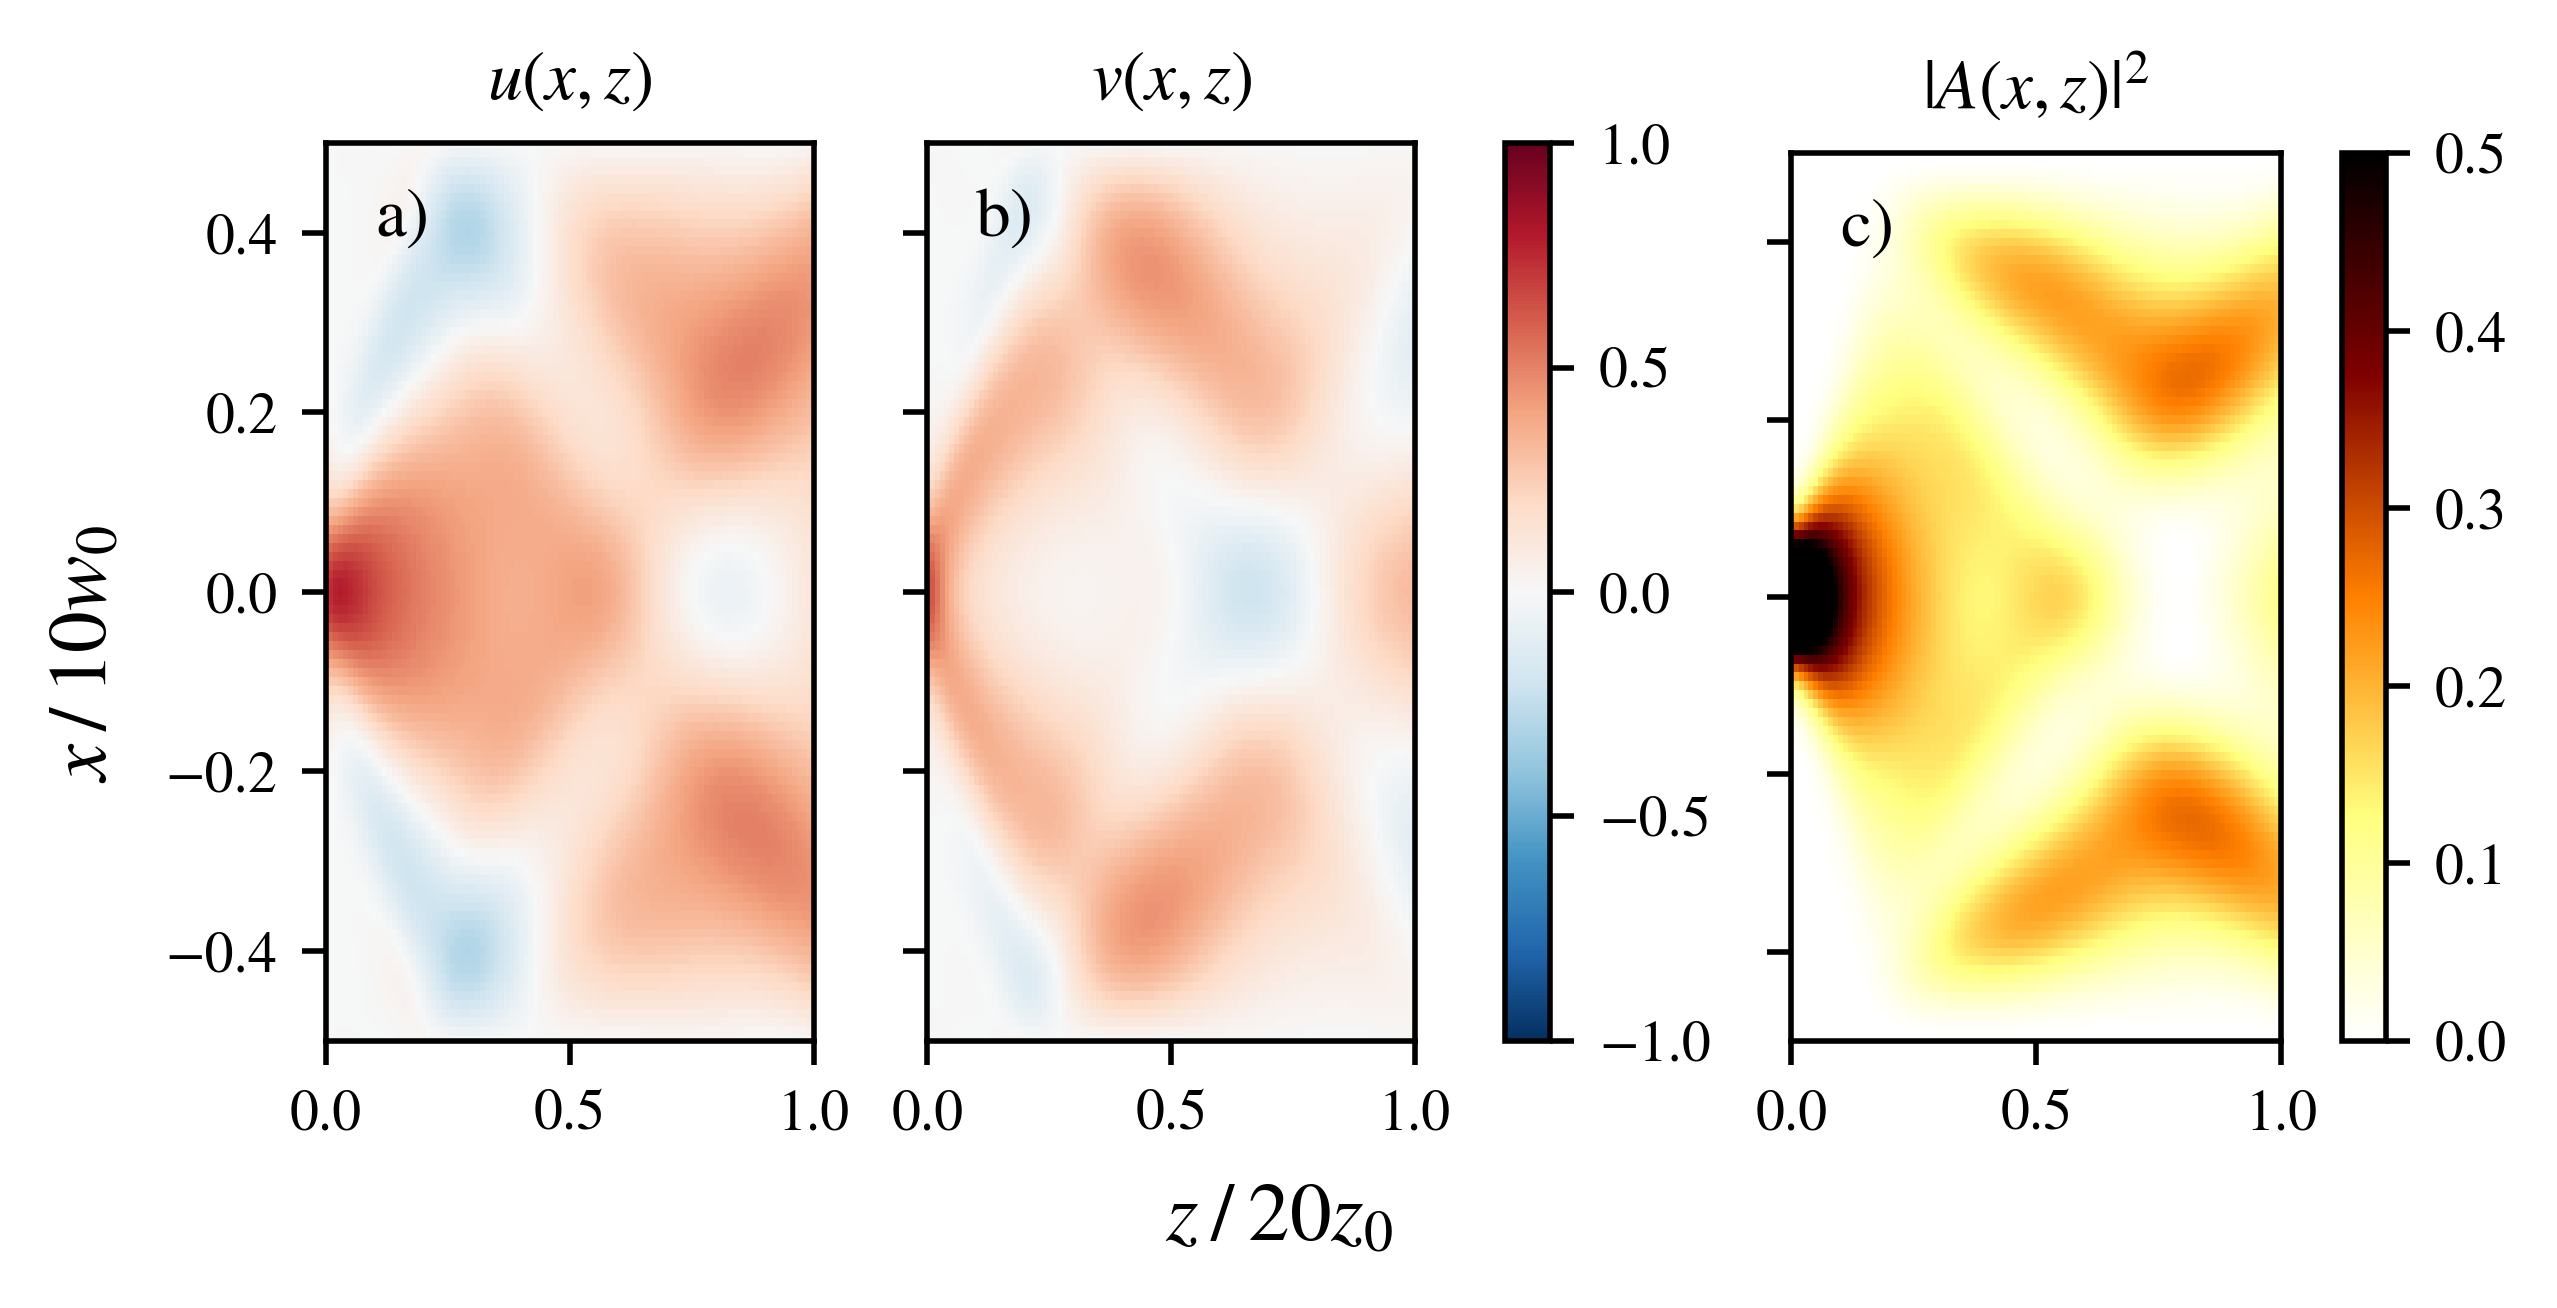

In [35]:
plot_model2()

In [33]:
#beam_diameter_exact(xtest, ztest)

In [34]:
#beam_diameter_predict(xtest, ztest)

In [35]:
#beam_diameter_compare(xtest, ztest)

In [36]:
#plot_compare_2D()

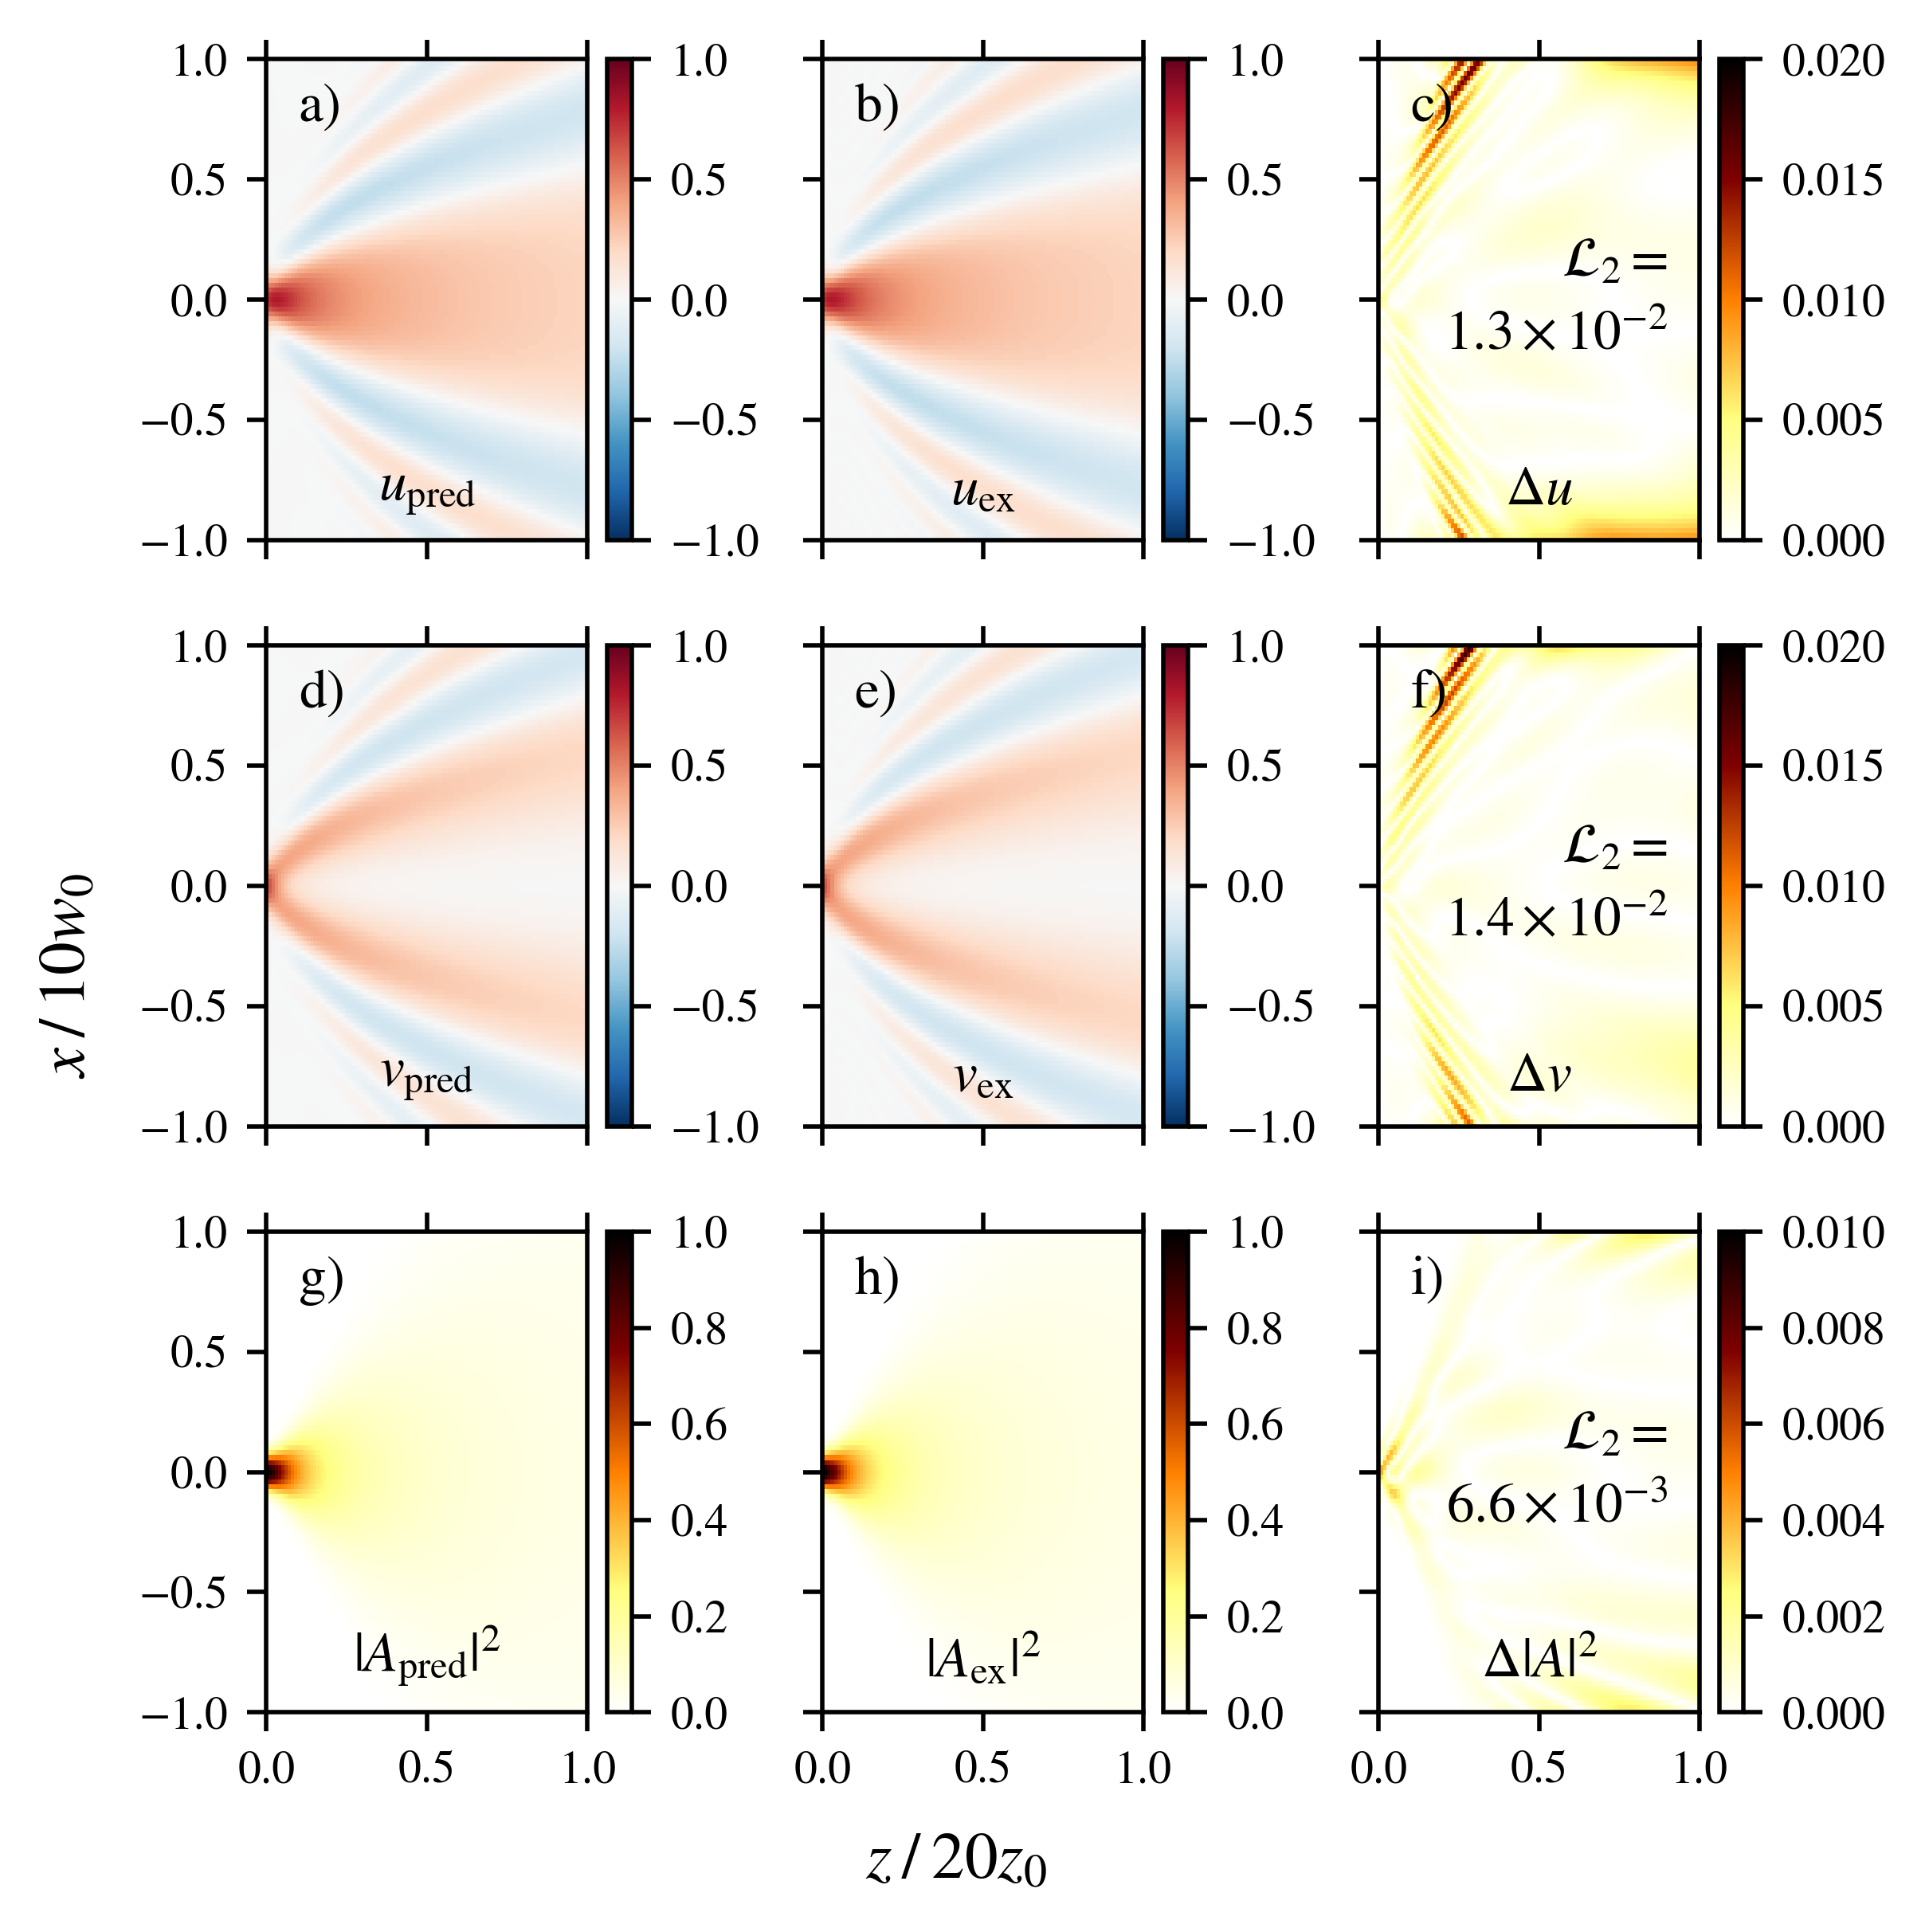

Relative L2 error for u is  0.013281725920963347
Relative L2 error for v is  0.013647219364914615
Relative L2 error for intensity is  0.006647966191613881


In [76]:
plot_compare_all()

In [38]:
#initial_condition_compare()

In [39]:
#end_solution_compare()

0.3


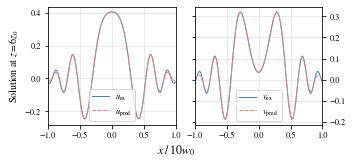

In [41]:
mid_solution_compare()

In [181]:
def track_progress():
    u_comp = u_exact_np(x_npmesh, z_npmesh)
    v_comp = v_exact_np(x_npmesh, z_npmesh)
    iterations = [500, 1500, 8000, 12000]
    letters = ['a)', 'b)', 'c)', 'd)', 'e)']
    
    fig, axes = plt.subplots(1,5, figsize=(5,2.5), dpi=500)
    
    for i in range(4):
        model.load_weights(f'weights/{iterations[i]}')

        A_plot = model(XZtest)
        u_plot_pre = A_plot[:, 0:1]
        v_plot_pre = A_plot[:, 1:2]

        u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
        v_plot = v_plot_pre.numpy().reshape(N_test, N_test)

        intens = u_plot**2 + v_plot**2
        
        line = axes[i].pcolormesh(ztestm, xtestm, intens, cmap = cm.afmhot_r, vmin=0, vmax=.2)#, norm=colors.LogNorm(vmin=1e-5, vmax=1))
        axes[i].text(0.12, -0.9, str(iterations[i]), fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=props)
        axes[i].text(0.91, -0.9, letters[i], fontsize=10, verticalalignment='bottom', horizontalalignment='right')
        axes[i].set_xticks([0, 0.5])
        
        if i != 0:
            axes[i].set_yticklabels([])
            
        axes[i].set_xlim(z_lb, z_ub)
        axes[i].set_ylim(x_lb, x_ub)
        
    line2 = axes[4].pcolormesh(ztestm, xtestm, u_comp**2 + v_comp**2, cmap = cm.afmhot_r, vmin=0, vmax=.2)#, norm=colors.LogNorm(vmin=intens.min(), vmax=intens.max()),)
    #cbar = fig.colorbar(line, ax=axes[4])
    cbar = fig.colorbar(line2, ax=axes, location='right')
    cbar.set_label(r'$|A(x,z)|^2$')
    
    axes[4].text(0.12, -0.9, 'exact', fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=props)
    axes[4].set_xticks([0, 0.5, 1])
    axes[4].set_yticklabels([])
    axes[4].set_xlim(z_lb, z_ub)
    axes[4].set_ylim(x_lb, x_ub)
    axes[4].text(0.91, -0.9, letters[4], fontsize=10, verticalalignment='bottom', horizontalalignment='right')
        
    axes[2].text(0.5, 0.9, 'after Adam', fontsize=8, verticalalignment='top', horizontalalignment='center')    
    axes[3].text(0.5, 0.9, 'after L-BFGS', fontsize=8, verticalalignment='top', horizontalalignment='center')    
    
    fig.supylabel('$x \: / \: 10w_0$')
    fig.supxlabel('$z \: / \: 20z_0$', y=-0.05)#, y=.005)
    
    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, right=0.825)
    
    fig.savefig(f'{folder}/progress_calc{number}.png')
    fig.savefig(f'plots/{boundary_condition}/progress_calc{number}.png')
    plt.show()
    plt.close()

In [147]:
import matplotlib.colors as colors

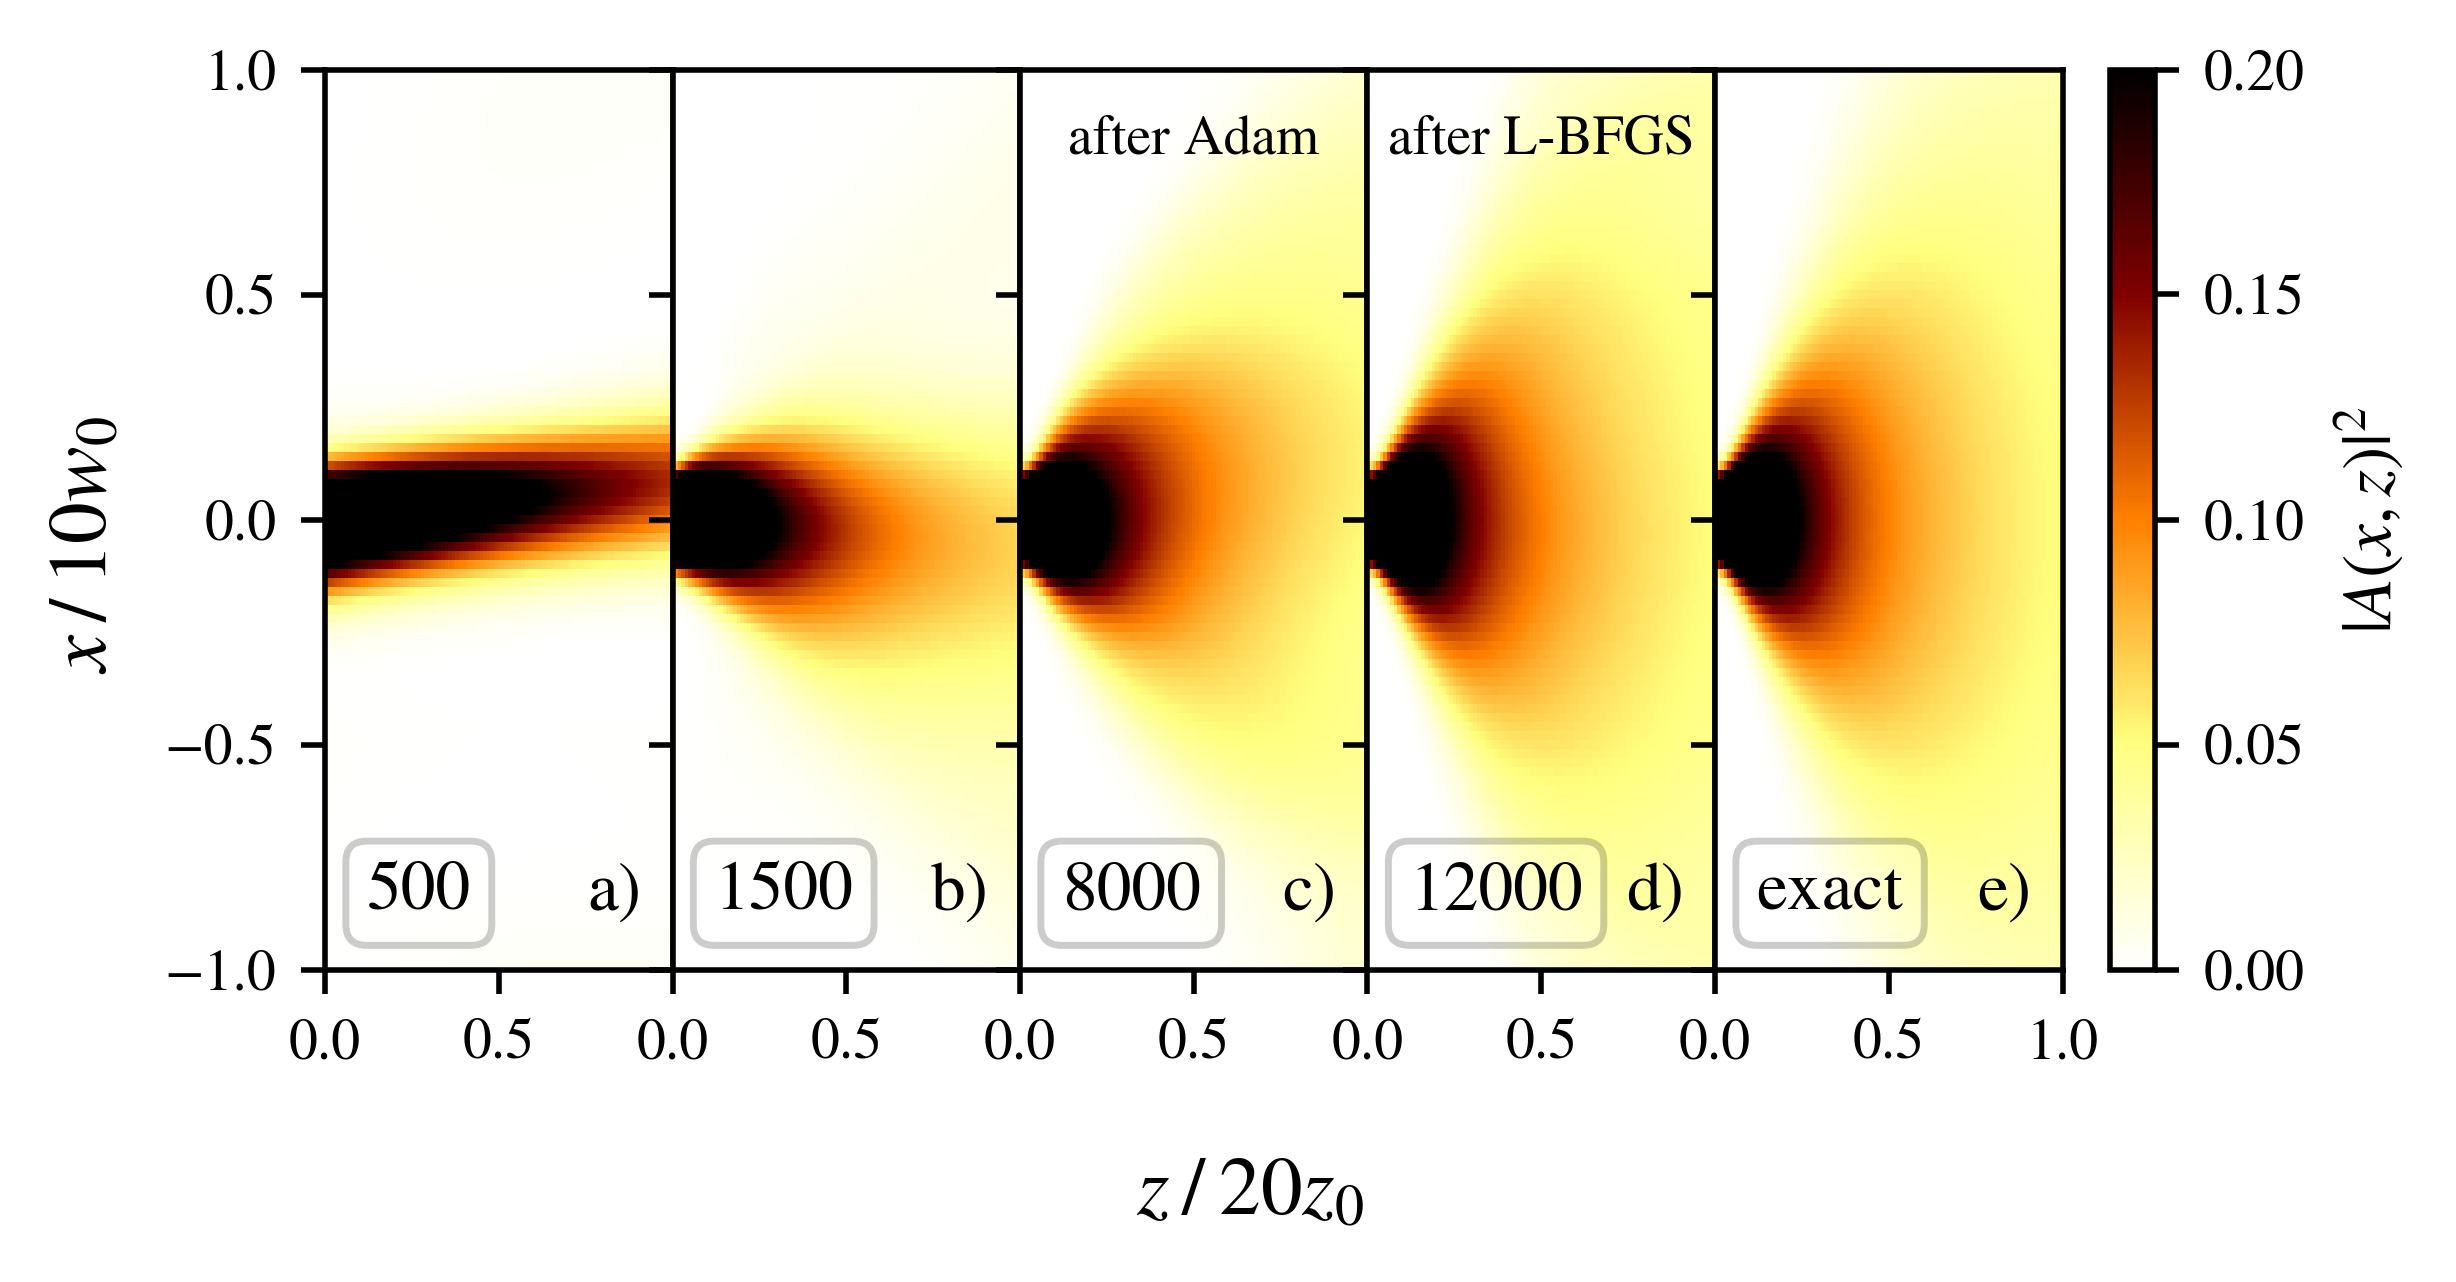

In [173]:
track_progress()

In [240]:
def track_progress2():
    u_comp = u_exact_np(x_npmesh, z_npmesh)
    v_comp = v_exact_np(x_npmesh, z_npmesh)
    iterations = [500, 1500, 8000, 12000]
    letters = ['a)', 'b)', 'c)', 'd)', 'e)']
    
    fig, axes = plt.subplots(1,5, figsize=(5,2.5), dpi=500)
    
    for i in range(4):
        model.load_weights(f'weights/{iterations[i]}')

        A_plot = model(XZtest)
        u_plot_pre = A_plot[:, 0:1]
        v_plot_pre = A_plot[:, 1:2]

        u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
        v_plot = v_plot_pre.numpy().reshape(N_test, N_test)

        intens = u_plot**2 + v_plot**2
        
        line = axes[i].pcolormesh(ztestm, xtestm, intens, cmap = cm.afmhot_r, norm=colors.LogNorm(vmin=1e-2, vmax=1))
        axes[i].text(0.12, -0.9, str(iterations[i]), fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=props)
        axes[i].text(0.08, 0.92, letters[i], fontsize=10, verticalalignment='top', horizontalalignment='left')
        axes[i].set_xticks([0, 0.5])
        
        if i != 0:
            axes[i].set_yticklabels([])
            
        axes[i].set_xlim(z_lb, z_ub)
        axes[i].set_ylim(x_lb, x_ub)
        
    fig.subplots_adjust(wspace=0, bottom=.2, top=.96)
    
    line2 = axes[4].pcolormesh(ztestm, xtestm, u_comp**2 + v_comp**2, cmap = cm.afmhot_r, norm=colors.LogNorm(vmin=1e-2, vmax=1))
    #cbar = fig.colorbar(line, ax=axes[4])
    cbar = fig.colorbar(line2, ax=axes, location='right')#, pad=2)#, shrink=1.1, aspect=20*0.9, pad=0.2)
    cbar.set_label(r'$|A(x,z)|^2$')
    
    axes[4].text(0.12, -0.9, 'exact', fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=props)
    axes[4].set_xticks([0, 0.5, 1])
    axes[4].set_yticklabels([])
    axes[4].set_xlim(z_lb, z_ub)
    axes[4].set_ylim(x_lb, x_ub)
    axes[4].text(0.08, 0.92, letters[4], fontsize=10, verticalalignment='top', horizontalalignment='left')
        
    axes[2].text(0.9, 0, 'after\nAdam', fontsize=8, verticalalignment='center', horizontalalignment='right')    
    axes[3].text(0.9, 0, 'after\nL-BFGS', fontsize=8, verticalalignment='center', horizontalalignment='right')    
    
    fig.supylabel('$x \: / \: 10w_0$', fontsize=10)
    axes[2].set_xlabel('$z \: / \: 20z_0$', fontsize=10)#, y=.005)
    
    #fig.tight_layout()
    fig.subplots_adjust(right=.82)
    
    fig.savefig(f'{folder}/progress2_calc{number}.png')
    fig.savefig(f'plots/{boundary_condition}/progress2_calc{number}.png')
    plt.show()
    plt.close()

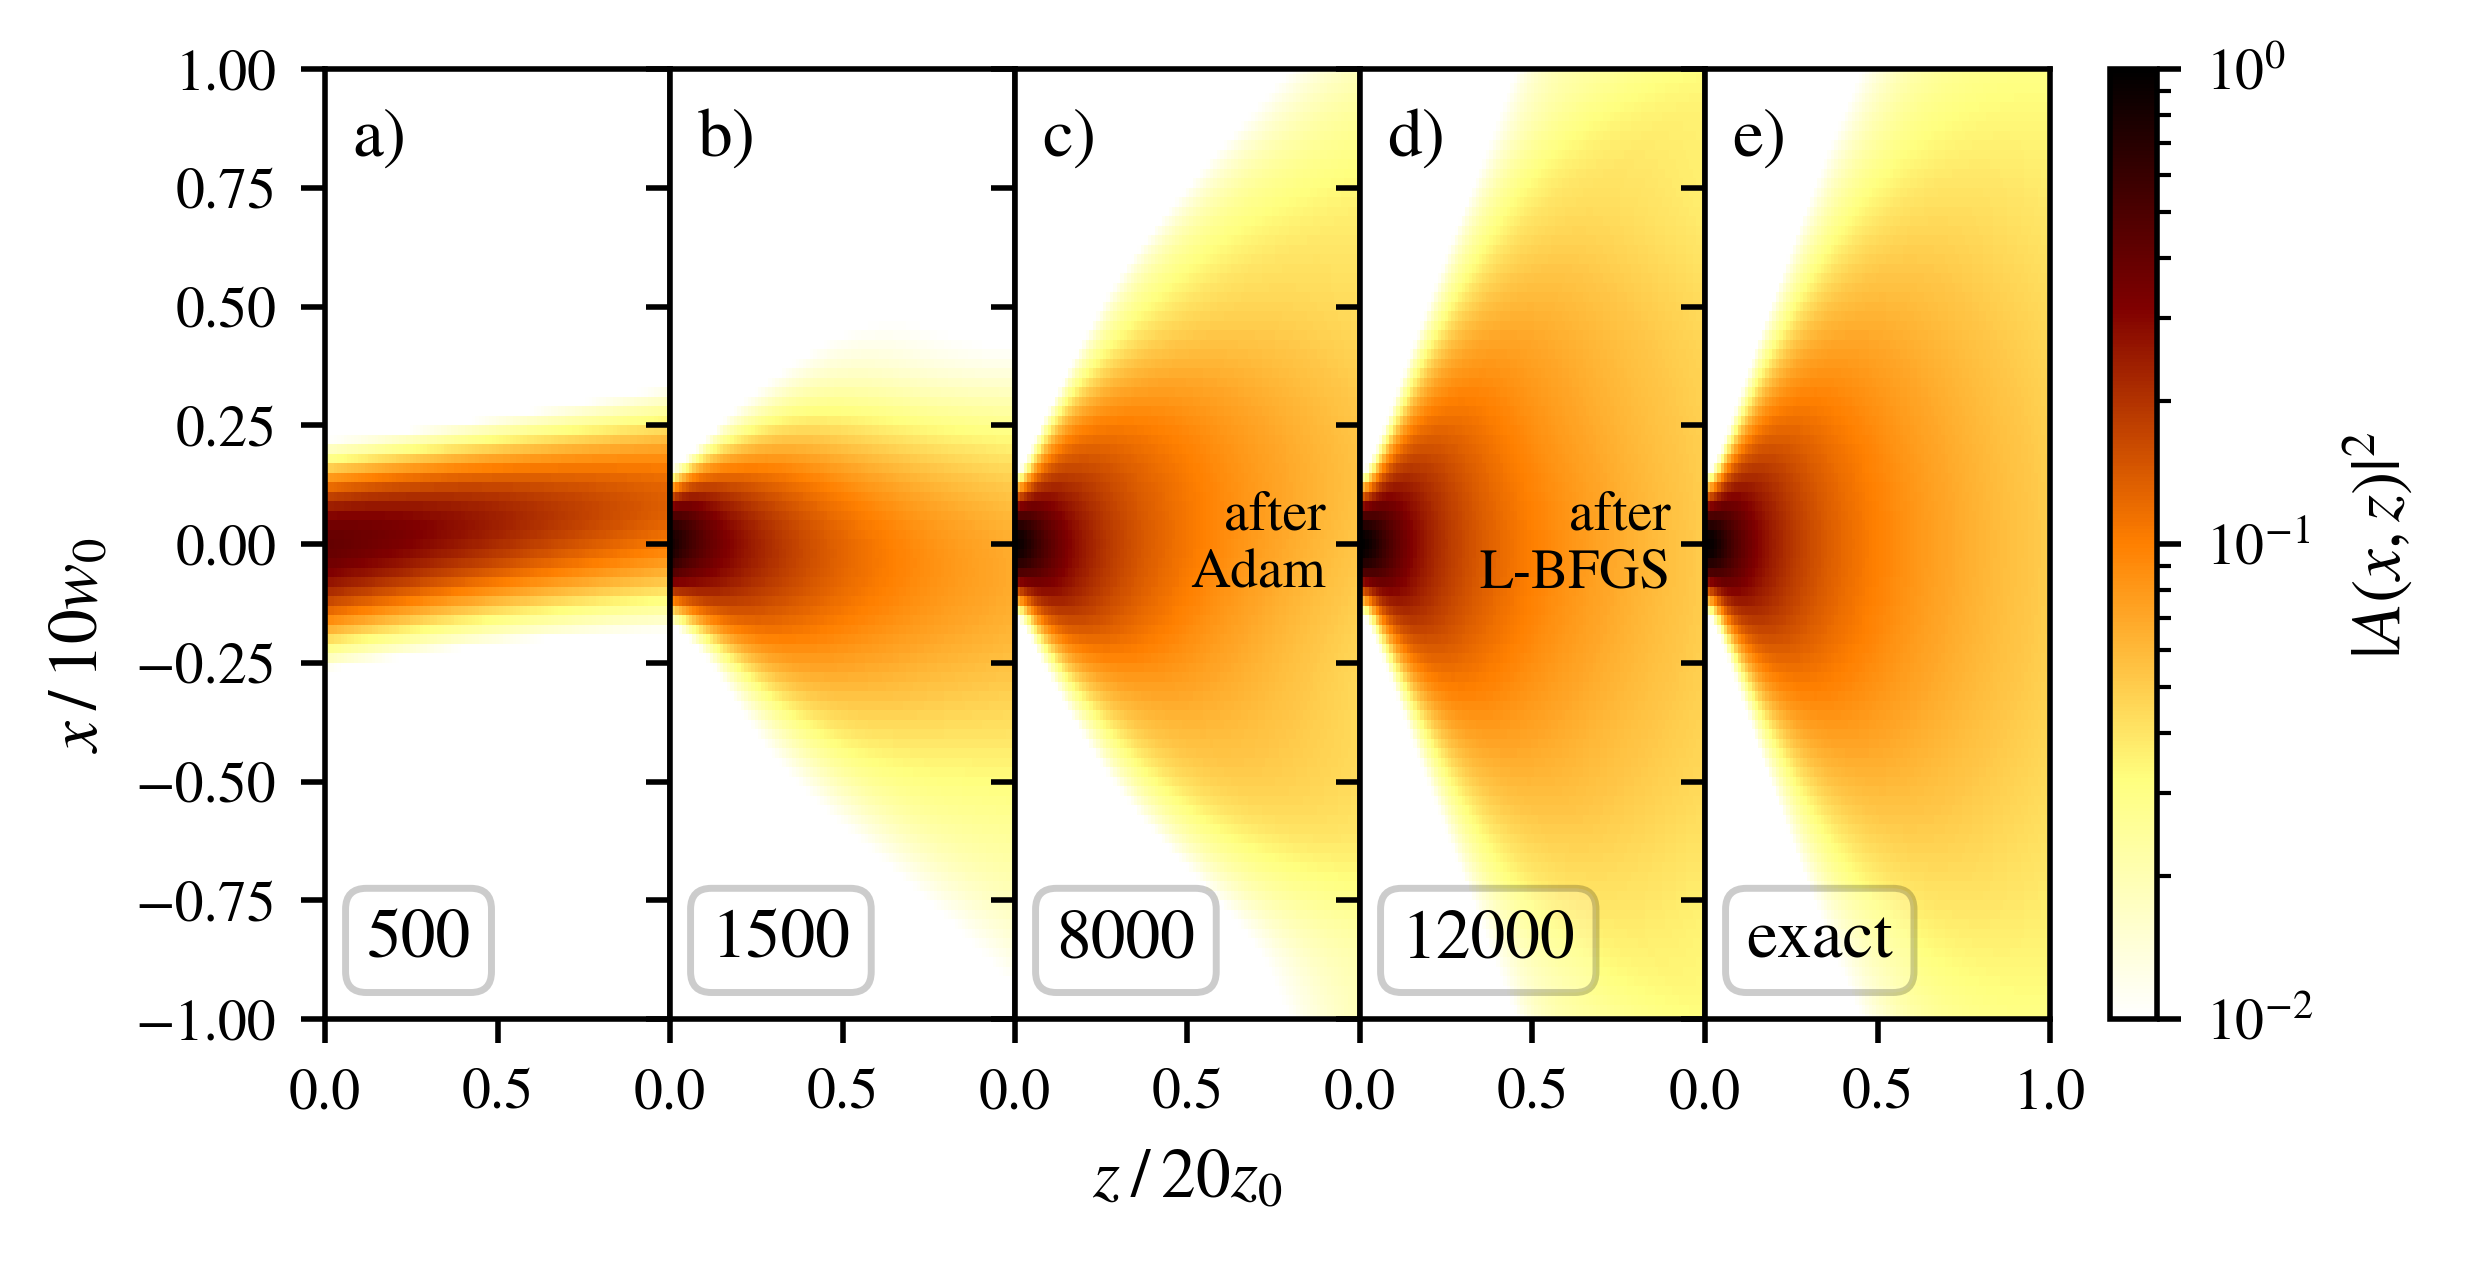

In [241]:
track_progress2()

In [33]:
print(np.arange(0, 17100, 100))

[    0   100   200   300   400   500   600   700   800   900  1000  1100
  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300
  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500
  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700
  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900
  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100
  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300
  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500
  9600  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700
 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900
 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100
 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300
 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500
 15600 15700 15800 15900 16000 16100 16200 16300 16

In [21]:
def physics():
    with tf.GradientTape(persistent=True) as tape:
        x_phy, z_phy = XZ[:, 0:1], XZ[:, 1:2]
        
        tape.watch(x_phy)
        tape.watch(z_phy)
        
        A_phy = model((tf.stack([x_phy[:,0], z_phy[:,0]], axis=1)))
        
        u_phy = A_phy[:, 0:1]
        v_phy = A_phy[:, 1:2]
        
        u_dx = tape.gradient(u_phy, x_phy)
        v_dx = tape.gradient(v_phy, x_phy)
        
    u_dz = tape.gradient(u_phy, z_phy)
    u_dx2 = tape.gradient(u_dx, x_phy)
    v_dz = tape.gradient(v_phy, z_phy)
    v_dx2 = tape.gradient(v_dx, x_phy)
    
    del tape
      
    real_resid = u_dx2 / 5 - 4 * v_dz
    imag_resid = v_dx2 / 5 + 4 * u_dz

    return real_resid, imag_resid

In [22]:
u0_exact = u_init(XZ0[:,0:1]) 
v0_exact = v_init(XZ0[:,0:1]) 

In [23]:
def compute_loss():
    real_resid, imag_resid = physics()
    
    A_init_pred = model(XZ0)
    u_init_pred = A_init_pred[:, 0:1]
    v_init_pred = A_init_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    loss = real_phi_pde + imag_phi_pde + u_phi_i + v_phi_i
        
    return float(loss)

In [24]:
def calculate_errors():
    
    epocharray = np.arange(0, 17100, 100)
    
    # FOR PLOTS

    x_np = np.linspace(x_lb, x_ub, num=N_test)
    z_np = np.linspace(z_lb, z_ub, num=N_test)

    x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)
    
    u_ref = u_exact_np(x_npmesh, z_npmesh)
    v_ref = v_exact_np(x_npmesh, z_npmesh)
    int_ref = u_ref**2 + v_ref**2
        
    for num in [27, 28]:
        loss = []
        l2u = []
        l2v = []
        l2int = []
        
        if num == 27:
            Nx = 10000
            Nz = 10000
            ls = '-'
        elif num == 28:
            Nx = 15000
            Nz = 15000
            ls = '--'
        
        x = tf.random.uniform((Nx, 1), x_lb, x_ub, dtype=DTYPE)
        z = tf.random.uniform((Nz, 1), z_lb, z_ub, dtype=DTYPE)
        XZ = tf.concat([x, z], axis=1)

        xtest = np.linspace(x_lb, x_ub, N_test)
        ztest = np.linspace(z_lb, z_ub, N_test)
        xtestm, ztestm = np.meshgrid(xtest, ztest)
        xtestm_resh = xtestm.flatten().reshape(N_test**2, 1)
        ztestm_resh = ztestm.flatten().reshape(N_test**2, 1)

        xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
        ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
        XZtest = tf.concat([xtestm_resh_tf, ztestm_resh_tf], axis=1)

        # x and z for initial condition

        z0 = tf.ones((Nbz, 1), dtype=DTYPE) * z_lb
        x0 = tf.random.uniform((Nbz, 1), x_lb, x_ub, dtype=DTYPE)
        XZ0 = tf.concat([x0, z0], axis=1)

        # x and z for boundary conditions

        zb = tf.random.uniform((Nbx, 1), z_lb, z_ub, dtype=DTYPE)
        xlb = tf.ones((Nbx, 1), dtype=DTYPE) * x_lb
        XZlb = tf.concat([xlb, zb], axis=1)
        xub = tf.ones((Nbx, 1), dtype=DTYPE) * x_ub
        XZub = tf.concat([xub, zb], axis=1)
        
        
        for epoch in epocharray:
            model.load_weights(f'weights/calc{num}/{epoch}')
            
            A_plot = model(XZtest)
            u_plot_pre = A_plot[:, 0:1]
            v_plot_pre = A_plot[:, 1:2]
            u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
            v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
            int_plot = u_plot**2 + v_plot**2

            u_diff = np.abs(u_ref - u_plot)
            v_diff = np.abs(v_ref - v_plot)
            int_diff = np.abs(int_ref - int_plot)
            
            l2_u = np.sqrt( np.sum(np.sum(u_diff**2, axis=1)) / np.sum(np.sum(u_ref**2, axis=1)) )
            l2_v = np.sqrt( np.sum(np.sum(v_diff**2, axis=1)) / np.sum(np.sum(v_ref**2, axis=1)) )
            l2_int = np.sqrt( np.sum(np.sum(int_diff**2, axis=1)) / np.sum(np.sum(int_ref**2, axis=1)) )
            
            l2u.append(l2_u)
            l2v.append(l2_v)
            l2int.append(l2_int)
            loss.append(compute_loss())
            
        np.savetxt(f'erroranalysis/l2u{num}.txt', l2u)
        np.savetxt(f'erroranalysis/l2v{num}.txt', l2v)
        np.savetxt(f'erroranalysis/l2int{num}.txt', l2int)
        np.savetxt(f'erroranalysis/loss{num}.txt', loss)

In [ ]:
def calculate_errors():
    
    epocharray = np.arange(0, 17100, 100)
    
    # FOR PLOTS

    x_np = np.linspace(x_lb, x_ub, num=N_test)
    z_np = np.linspace(z_lb, z_ub, num=N_test)

    x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)
    
    u_ref = u_exact_np(x_npmesh, z_npmesh)
    v_ref = v_exact_np(x_npmesh, z_npmesh)
    int_ref = u_ref**2 + v_ref**2
        
    for num in [27, 28]:
        loss = []
        l2u = []
        l2v = []
        l2int = []
        
        if num == 27:
            Nx = 10000
            Nz = 10000
            ls = '-'
        elif num == 28:
            Nx = 15000
            Nz = 15000
            ls = '--'
        
        x = tf.random.uniform((Nx, 1), x_lb, x_ub, dtype=DTYPE)
        z = tf.random.uniform((Nz, 1), z_lb, z_ub, dtype=DTYPE)
        XZ = tf.concat([x, z], axis=1)

        xtest = np.linspace(x_lb, x_ub, N_test)
        ztest = np.linspace(z_lb, z_ub, N_test)
        xtestm, ztestm = np.meshgrid(xtest, ztest)
        xtestm_resh = xtestm.flatten().reshape(N_test**2, 1)
        ztestm_resh = ztestm.flatten().reshape(N_test**2, 1)

        xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
        ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
        XZtest = tf.concat([xtestm_resh_tf, ztestm_resh_tf], axis=1)

        # x and z for initial condition

        z0 = tf.ones((Nbz, 1), dtype=DTYPE) * z_lb
        x0 = tf.random.uniform((Nbz, 1), x_lb, x_ub, dtype=DTYPE)
        XZ0 = tf.concat([x0, z0], axis=1)

        # x and z for boundary conditions

        zb = tf.random.uniform((Nbx, 1), z_lb, z_ub, dtype=DTYPE)
        xlb = tf.ones((Nbx, 1), dtype=DTYPE) * x_lb
        XZlb = tf.concat([xlb, zb], axis=1)
        xub = tf.ones((Nbx, 1), dtype=DTYPE) * x_ub
        XZub = tf.concat([xub, zb], axis=1)
        
        
        for epoch in epocharray:
            model.load_weights(f'weights/calc{num}/{epoch}')
            
            A_plot = model(XZtest)
            u_plot_pre = A_plot[:, 0:1]
            v_plot_pre = A_plot[:, 1:2]
            u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
            v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
            int_plot = u_plot**2 + v_plot**2

            u_diff = np.abs(u_ref - u_plot)
            v_diff = np.abs(v_ref - v_plot)
            int_diff = np.abs(int_ref - int_plot)
            
            l2_u = np.sqrt( np.sum(np.sum(u_diff**2, axis=1)) / np.sum(np.sum(u_ref**2, axis=1)) )
            l2_v = np.sqrt( np.sum(np.sum(v_diff**2, axis=1)) / np.sum(np.sum(v_ref**2, axis=1)) )
            l2_int = np.sqrt( np.sum(np.sum(int_diff**2, axis=1)) / np.sum(np.sum(int_ref**2, axis=1)) )
            
            l2u.append(l2_u)
            l2v.append(l2_v)
            l2int.append(l2_int)
            loss.append(compute_loss())
            
        np.savetxt(f'erroranalysis/26_l2u{num}.txt', l2u)
        np.savetxt(f'erroranalysis/26_l2v{num}.txt', l2v)
        np.savetxt(f'erroranalysis/26_l2int{num}.txt', l2int)
        np.savetxt(f'erroranalysis/26_loss{num}.txt', loss)

In [23]:
def compare_errors():
    
    epocharray = np.arange(0, 17100, 100)
    
    # FOR PLOTS
    
    fig, ax = plt.subplots(1, figsize=(5,3))
    
    ax2 = ax.twinx()
    
    for num in [27, 28]:
        
        if num == 27:
            ls = '-'
        elif num == 28:
            ls = '--'

        l2u = np.loadtxt(f'erroranalysis/l2u{num}.txt')
        l2v = np.loadtxt(f'erroranalysis/l2v{num}.txt')
        l2int = np.loadtxt(f'erroranalysis/l2int{num}.txt')
        loss = np.loadtxt(f'erroranalysis/loss{num}.txt')
            
        line1, = ax2.plot(epocharray, loss, color='steelblue', linestyle=ls)
        line2, = ax.plot(epocharray, l2u, color='salmon', linestyle=ls)
        line3, = ax.plot(epocharray, l2v, color='yellowgreen', linestyle=ls)
        line4, = ax.plot(epocharray, l2int, color='mediumorchid', linestyle=ls)
        
        if num == 27:
            line1.set_label(r'Cost $J$')
            line2.set_label(r'$\mathcal{L}_2$ ($u$)')
            line3.set_label(r'$\mathcal{L}_2$ ($v$)')
            line4.set_label(r'$\mathcal{L}_2$ ($|A|^2$)')
        
        #ax2.scatter(epocharray, loss, color='steelblue', marker='.')
        #ax.scatter(epocharray, l2u, color='salmon', marker='s')
        #ax.scatter(epocharray, l2v, color='yellowgreen', marker='v')
        #ax.scatter(epocharray, l2int, color='mediumorchid', marker='D')
    
    ax.plot([-1, -2], [1,1], color='steelblue', linestyle='-', label=r'Cost')

    ax.plot([-1, -2], [1,1], color='gray', linestyle='-', label='$m_f = 10 \, 000$')
    ax.plot([-1, -2], [1,1], color='gray', linestyle='--', label='$m_f = 15 \, 000$')
    
    ax.set_yscale('log')
    ax2.set_yscale('log')
    
    ax.set_xlim(0, 17000)
    ax.grid(True)
    ax.legend(loc='upper right', ncol=3)
    #ax2.legend(loc='lower left', ncol=1)
    
    ax.set_xlabel('number of training iterations')
    ax.set_ylabel(r'relative $\mathcal{L}_2$ error (log.)')
    ax2.set_ylabel(r'Total cost $J$ (log.)')
    
    fig.tight_layout()
    fig.savefig(f'{folder}/comparison_error_27_28.pdf')
    fig.savefig(f'plots/{boundary_condition}/comparison_error_27_28.pdf')
    plt.show()
    plt.close()

In [26]:
#calculate_errors()

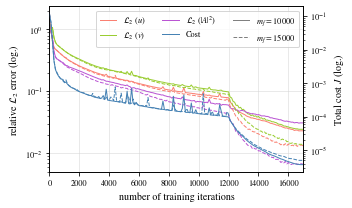

In [24]:
compare_errors()